# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [1]:

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random
from sklearn.metrics.pairwise import cosine_similarity



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine2 import config


dataset = "DREAMACHINE"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")


Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [2]:

sentences = True
random_seed = SEED # uses the global seed 

# Outlier reduction settings
reduce_outliers = True
outlier_strategy = 'probabilities' 
outlier_threshold = 0.15


### Load and preprocess data


In [3]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)

results_dir = os.path.join(project_root, "RESULTS")
results_filename = f"GS_results_{condition}_{'sentences' if sentences else ''}.csv"
results_path = os.path.join(results_dir, results_filename)

print("Loading results from:", results_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/HS_reflections_APIcleaned.csv
Loading results from: /Users/rb666/Projects/MOSAIC/RESULTS/GS_results_HS_sentences.csv


0      Intense chaos. And then my mind checked out an...
1                                            Good stuff.
2      A pattern of red and white lights that flashed...
3      I went back to many hard and mostly beautiful ...
4                                                 Hello.
                             ...                        
328    Changing temperature of my body with the light...
329                                 Pleasure & intrigue.
330                            Travelling through space.
331    I thought a lot about Rand's journey into Rhui...
332    The visual here doesn't look anything like wha...
Name: cleaned_reflection, Length: 333, dtype: object

### Pre-processing


In [4]:
if sentences:
    df_reports = split_sentences(df_reports)[0]

print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


Successfully loaded and processed 736 sentences.


In [5]:
min_words = 2 #threshold for minimum words in a sentence

#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")


Hello.
Devtest.
Confusion.
Vast.
Immense.
Tessellations.
Hexagons.
Joy.
Starfields.
devtest
l
it
Beautiful!
Thanks!
Euphoria
Unease
Bizarre.
Everything.
Pareidolia.
Soothed.
Tired.
Joy.
Calm
Warm
h
cakm
Anxiety.
l8
Vertigo.
Peace.
Peace.
Sunlight.
True.

There are 33 sentences with less than 2 words.

After removing short sentences, 703 sentences remain.


In [6]:
#check if there are any duplicate sentences (lists) and remove them
duplicates = [sentence for sentence in df_reports if df_reports.count(sentence) > 1]
df_reports = [sentence for sentence in df_reports if sentence not in duplicates]
print(f"After removing duplicates, {len(df_reports)} sentences remain.\n")

After removing duplicates, 697 sentences remain.



### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [7]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Setup representation model (before LLM)

In [8]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

### Train BERTopic model 

In [9]:
### Chose either to load best params from grid search or use defaults tailored ones from the config file
# #  Load best params from grid search
# results_GS = pd.read_csv(results_path)
# chosen_params = results_GS.iloc[0]
# print("Best parameters loaded from grid search:")
# print(chosen_params)


# Load default parameters directly from the config
print(f"Loading default parameters for condition: {condition}")
chosen_params = config.get_default_params(condition)

# Print as a Series for nice formatting, similar to the old output
print("Default parameters loaded:")
print(pd.Series(chosen_params))

Loading default parameters for condition: HS
Default parameters loaded:
n_neighbors         15.0
n_components        10.0
min_dist             0.0
min_cluster_size    10.0
min_samples          5.0
top_n_words         15.0
dtype: float64


In [10]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words= 15,#int(chosen_params['top_n_words']), #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

2025-09-22 16:50:21,954 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-22 16:50:26,329 - BERTopic - Dimensionality - Completed ✓
2025-09-22 16:50:26,329 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-22 16:50:26,361 - BERTopic - Cluster - Completed ✓
2025-09-22 16:50:26,362 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-09-22 16:50:26,380 - BERTopic - Representation - Completed ✓
2025-09-22 16:50:26,381 - BERTopic - Topic reduction - Reducing number of topics
2025-09-22 16:50:26,385 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-22 16:50:30,684 - BERTopic - Representation - Completed ✓
2025-09-22 16:50:30,685 - BERTopic - Topic reduction - Reduced number of topics from 15 to 12


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [11]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,170,-1_experience_like_felt_brain,"[experience, like, felt, brain, would, music, ...","[felt like, feel like, feeling, euphoric, amaz...","[experience, brain, body, images, colors, flyi...",[Thought of how amazing my mind is to make up ...
1,0,177,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...
2,1,102,1_space_felt_universe_floating,"[space, felt, universe, floating, like, body, ...","[felt like, space, could see, end felt, someti...","[space, universe, floating, felt like, flying,...","[I felt in clouds, holding my breath., Like I ..."
3,2,48,2_calm_peace_music_relaxation,"[calm, peace, music, relaxation, joy, calming,...","[sense peace, calm relaxing, moments calm, cal...","[calm, relaxation, calming, relaxing, peaceful...","[Utter peace and happiness., Peace and content..."
4,3,38,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, moving, t...","[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_back_old_felt like,"[memories, back, old, felt like, place, strong...","[felt like, past memories, memories, looking b...","[memories, felt like, feeling, womb, house, be...",[I could walk around the room and almost reach...
6,5,31,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, thoughts felt, felt like, a...","[asleep, thoughts, mind, dreaming, brain, awak...",[I also felt asleep for a bit and I was thinki...
7,6,29,6_experience_interesting_good_amazing,"[experience, interesting, good, amazing, wonde...","[interesting experience, unique experience, ex...","[experience, interesting, wonderful, experienc...","[Awesome experience and not what I expected., ..."
8,7,26,7_felt_relaxed_felt relaxed_safe,"[felt, relaxed, felt relaxed, safe, also felt,...","[felt relaxed, relaxing, calm relaxing, intere...","[felt relaxed, also felt, relaxing, relaxation...","[I felt relaxed, safe, and excited at the star..."
9,8,20,8_eyes_light_lights_made,"[eyes, light, lights, made, intensity, focused...","[lights, flashing lights, lighting, visual exp...","[eyes, light, lights, made feel, flashing, fla...",[I would have liked a slight diffusion on the ...


In [12]:
docs_info = topic_model.get_document_info(df_reports)
docs_info

,Document,Topic,Name,Representation,KeyBERT,MMR,Representative_Docs,Top_n_words,Probability,Representative_document
0,Intense chaos.,3,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, moving, t...","[Journey forward., A loss of sense of time, im...",journey - time - sense - sense time - forward ...,0.116409,False
1,And then my mind checked out and my subconscio...,5,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, thoughts felt, felt like, a...","[asleep, thoughts, mind, dreaming, brain, awak...",[I also felt asleep for a bit and I was thinki...,asleep - thoughts - thinking - mind - quite - ...,0.583515,False
2,What I imagine it's like looking back on life ...,10,10_death_life_like_could,"[death, life, like, could, imagine, visual thi...","[death, life, looking back, imagine, something...","[death, life, imagine, visual thing, looking b...",[The cycle of death and rebirth as envisaged i...,death - life - like - could - imagine - visual...,1.000000,False
3,Good stuff.,6,6_experience_interesting_good_amazing,"[experience, interesting, good, amazing, wonde...","[interesting experience, unique experience, ex...","[experience, interesting, wonderful, experienc...","[Awesome experience and not what I expected., ...",experience - interesting - good - amazing - wo...,0.350811,False
4,A pattern of red and white lights that flashed...,0,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...,saw - shapes - patterns - colours - like - kal...,0.596079,False
...,...,...,...,...,...,...,...,...,...,...
692,Pleasure & intrigue.,-1,-1_experience_like_felt_brain,"[experience, like, felt, brain, would, music, ...","[felt like, feel like, feeling, euphoric, amaz...","[experience, brain, body, images, colors, flyi...",[Thought of how amazing my mind is to make up ...,experience - like - felt - brain - would - mus...,0.467323,False
693,Travelling through space.,-1,-1_experience_like_felt_brain,"[experience, like, felt, brain, would, music, ...","[felt like, feel like, feeling, euphoric, amaz...","[experience, brain, body, images, colors, flyi...",[Thought of how amazing my mind is to make up ...,experience - like - felt - brain - would - mus...,0.656832,False
694,I thought a lot about Rand's journey into Rhui...,1,1_space_felt_universe_floating,"[space, felt, universe, floating, like, body, ...","[felt like, space, could see, end felt, someti...","[space, universe, floating, felt like, flying,...","[I felt in clouds, holding my breath., Like I ...",space - felt - universe - floating - like - bo...,1.000000,False
695,The visual here doesn't look anything like wha...,-1,-1_experience_like_felt_brain,"[experience, like, felt, brain, would, music, ...","[felt like, feel like, feeling, euphoric, amaz...","[experience, brain, body, images, colors, flyi...",[Thought of how amazing my mind is to make up ...,experience - like - felt - brain - would - mus...,0.683285,False


### Initial analysis (before LLM)

In [13]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
print(f"\nInitial Coherence Score (C_v): {initial_coherence}")
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")



Number of valid topics used for coherence calculation (excludes outliers -1): 11

Initial Coherence Score (C_v): 0.42781432801154134
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


### Embedding coherence

In [14]:
# --- For Testing: Define Embedding Coherence Function ---
from sklearn.metrics.pairwise import cosine_similarity


def calculate_embedding_coherence(model, docs, embeddings):
    """
    Calculate the average intra-topic cosine similarity for a BERTopic model.

    Args:
        model (BERTopic): A fitted BERTopic model.
        docs (list of str): The original documents used to fit the model.
        embeddings (np.ndarray): The document embeddings for the training data.

    Returns:
        float: The mean coherence score across all topics.
    """
    # Group documents and their embeddings by topic
    # The original documents ('docs') must be used here to match the length of model.topics_
    documents_df = pd.DataFrame({"Doc": docs, "Topic": model.topics_})
    
    # Ensure embeddings are a numpy array
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array(embeddings)
        
    documents_df['Embedding'] = list(embeddings)

    # Calculate coherence for each topic
    topic_coherence_scores = []
    for topic_id in documents_df['Topic'].unique():
        if topic_id == -1:  # Skip outlier topic
            continue
        
        topic_docs_df = documents_df[documents_df['Topic'] == topic_id]
        
        if len(topic_docs_df) < 2: # Cannot calculate coherence for a single document
            continue

        topic_embeddings = np.vstack(topic_docs_df['Embedding'].values)
        
        # Calculate pairwise similarity and get the mean of the upper triangle
        similarity_matrix = cosine_similarity(topic_embeddings)
        upper_triangle_mean = np.mean(similarity_matrix[np.triu_indices(len(topic_docs_df), k=1)])
        topic_coherence_scores.append(upper_triangle_mean)

    # Return the mean coherence across all topics, or 0.0 if no valid topics found
    return np.mean(topic_coherence_scores) if topic_coherence_scores else 0.0

In [15]:
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Initial Word-Based Coherence Score (C_v): 0.4278
Initial Embedding Coherence Score: 0.5859
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


In [16]:
# reduce outliers (optional)
if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")

2025-09-22 16:50:33,269 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Reducing outliers using the 'probabilities' strategy with threshold 0.15...
Remaining outliers after reduction: 97
Number of valid topics used for coherence calculation (excludes outliers -1): 11
Coherence Score after outlier reduction: 0.4116883089350079


In [17]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [18]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [19]:
#print list of keywords for each topic
for topic_id in range(len(topic_model.get_topic_info()) - 1): # Exclude outlier topic
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")
# Save the model

Topic 0: ['and', 'of', 'saw', 'the', 'shapes', 'colours', 'like', 'patterns', 'in', 'as']
Topic 1: ['was', 'the', 'felt', 'it', 'and', 'to', 'in', 'of', 'space', 'through']
Topic 2: ['calm', 'music', 'peace', 'and', 'relaxation', 'the', 'sense', 'joy', 'calming', 'relaxing']
Topic 3: ['time', 'sense', 'journey', 'of', 'forward', 'fast', 'speed', 'through', 'images', 'and']
Topic 4: ['memories', 'my', 'to', 'back', 'and', 'felt', 'like', 'old', 'place', 'it']
Topic 5: ['my', 'asleep', 'thoughts', 'dreaming', 'had', 'was', 'what', 'thinking', 'mind', 'quite']
Topic 6: ['experience', 'interesting', 'very', 'it', 'good', 'amazing', 'expected', 'thank', 'awesome', 'wonderful']
Topic 7: ['felt', 'relaxed', 'and', 'was', 'safe', 'also', 'of', 'sense', 'very', 'at']
Topic 8: ['the', 'to', 'on', 'my', 'me', 'eyes', 'light', 'of', 'lights', 'made']
Topic 9: ['drugs', 'on', 'lsd', 'dmt', 'closest', 'an', 'psychedelic', 'perhaps', 'being', 'having']
Topic 10: ['death', 'life', 'like', 'it', 'die',

In [20]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from KeyBERT and MMR Representations ---

Topic 0:
  - KeyBERT: ['colours shapes', 'kaleidoscopic', 'kaleidoscope', 'yellow like', 'shapes', 'vivid', 'patterns made', 'colours', 'shape', 'colors']
  - MMR:     ['saw', 'shapes', 'patterns', 'colours', 'kaleidoscope', 'blue', 'geometric', 'kaleidoscopic', 'vision', 'eye']

Topic 1:
  - KeyBERT: ['felt like', 'space', 'could see', 'end felt', 'sometimes felt', 'universe', 'sky', 'felt though', 'feeling', 'flying']
  - MMR:     ['space', 'universe', 'floating', 'felt like', 'flying', 'sensation', 'portal', 'planet', 'journey', 'sometimes felt']

Topic 2:
  - KeyBERT: ['sense peace', 'calm relaxing', 'moments calm', 'calm', 'peace', 'calming', 'peaceful', 'stillness', 'relaxing', 'relaxation']
  - MMR:     ['calm', 'relaxation', 'calming', 'relaxing', 'peaceful', 'sense peace', 'louder music', 'moments calm', 'serene', 'feelings']

Topic 3:
  - KeyBERT: ['sense time', 'moving towards', 'towards something', 'motion', 'moving', '

# Update model with LLAMA 3 for Topic Labelling

In [21]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [22]:
from bertopic.representation import BaseRepresentation
import re

class MultiKeywordLLM(BaseRepresentation):
    def __init__(self, llm, prompt, pipeline_kwargs,nr_docs=10):
        super().__init__()
        self.llm = llm
        self.prompt = prompt
        self.pipeline_kwargs = pipeline_kwargs
        self.nr_docs = nr_docs 

    def extract_topics(self, topic_model, documents, c_tf_idf, topics):
        """
        This is the main function. For each topic, it will build a custom
        prompt and generate a new label.
        """
        # Get the topic info DataFrame that contains KeyBERT and MMR keywords
        topic_info_df = topic_model.get_topic_info()
        
        # Create the new labels
        new_labels = {}
        for index, row in topic_info_df.iterrows():
            topic_id = row['Topic']
            if topic_id == -1:
                continue

            # Get documents and all keyword sets for the current topic
            docs_to_use = topic_model.representative_docs_[topic_id][:self.nr_docs]
            docs = "\n".join(docs_to_use)

            ctfidf_kws = ", ".join([word for word, score in topic_model.get_topic(topic_id)])
            keybert_kws = ", ".join(row['KeyBERT'])
            mmr_kws = ", ".join(row['MMR'])
            
            # Fill in our detailed prompt
            filled_prompt = self.prompt.replace("[DOCUMENTS]", docs)
            filled_prompt = filled_prompt.replace("[KEYWORDS]", ctfidf_kws)
            filled_prompt = filled_prompt.replace("[KEYBERT_KEYWORDS]", keybert_kws)
            filled_prompt = filled_prompt.replace("[MMR_KEYWORDS]", mmr_kws)

            # Get the new label from the LLM
            response = self.llm(prompt=filled_prompt, **self.pipeline_kwargs)
            label = response['choices'][0]['text'].strip()
            new_labels[topic_id] = re.sub(r'^\d+\.\s*', '', label)
        
        return new_labels
    
prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

prompt_with_all_keywords = """Below are documents and keyword sets that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]
- [MMR_KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

# Your original pipeline kwargs
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.3,
    "top_p": 0.7,
    "repeat_penalty": 2
}

# Instantiate our new custom model
custom_llm_model = MultiKeywordLLM(llm, prompt=prompt_with_all_keywords, pipeline_kwargs=pipeline_kwargs,nr_docs = 10)
llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)

# Define the representation model using our custom class
representation_model = {"LLM_Custom": custom_llm_model,"LLM": llm_model}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama3 prompt...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

# You can now get your new, improved labels
topic_model.get_topic_info()

Updating topic representations with custom Llama3 prompt...


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]

Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM_Custom,LLM,Representative_Docs
0,-1,97,-1_the_my_and_it,"[the, my, and, it, to, of, in, was, brain, ins...","[felt like, feel like, feeling, euphoric, amaz...","[experience, brain, body, images, colors, flyi...",NaN,[Subjective Experience of Synesthesia and Brai...,[Thought of how amazing my mind is to make up ...
1,0,198,0_and_of_saw_the,"[and, of, saw, the, shapes, colours, like, pat...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",Optical Phenomena of Kaleidoscopic Patterns an...,"[""Visual Synesthesia Experience with Geometric...",[I saw many kinds of patterns from sparks to g...
2,1,150,1_was_the_felt_it,"[was, the, felt, it, and, to, in, of, space, t...","[felt like, space, could see, end felt, someti...","[space, universe, floating, felt like, flying,...",Out-of-Body Experience in Space-like Environme...,"[""Subjective Experience of Cosmic Consciousnes...","[I felt in clouds, holding my breath., Like I ..."
3,2,48,2_calm_music_peace_and,"[calm, music, peace, and, relaxation, the, sen...","[sense peace, calm relaxing, moments calm, cal...","[calm, relaxation, calming, relaxing, peaceful...",Calm and Relaxing Sensory Experience\n```\n\nT...,[Musical Induced Relaxation and Calming Experi...,"[Utter peace and happiness., Peace and content..."
4,3,39,3_time_sense_journey_of,"[time, sense, journey, of, forward, fast, spee...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, moving, t...","Time Perception During High-Speed Motion\n""""""\...","[""Perceptual Disruptions During Temporal Progr...","[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_my_to_back,"[memories, my, to, back, and, felt, like, old,...","[felt like, past memories, memories, looking b...","[memories, felt like, feeling, womb, house, be...",Vivid Memories of Past Places and Events\n```\...,"[""Episodic Memory Recall and Nostalgic Longing...",[I could walk around the room and almost reach...
6,5,33,5_my_asleep_thoughts_dreaming,"[my, asleep, thoughts, dreaming, had, was, wha...","[dreaming, asleep, thoughts felt, felt like, a...","[asleep, thoughts, mind, dreaming, brain, awak...",Dreamlike State of Semiconsciousness\n```\n\nT...,[Mind-Wandering and Dreamlike States During Me...,[I also felt asleep for a bit and I was thinki...
7,6,30,6_experience_interesting_very_it,"[experience, interesting, very, it, good, amaz...","[interesting experience, unique experience, ex...","[experience, interesting, wonderful, experienc...",Unexpectedly Positive Experience\n```\n\nThe t...,"[Synesthetic Experience Description, , , , , ,...","[Awesome experience and not what I expected., ..."
8,7,26,7_felt_relaxed_and_was,"[felt, relaxed, and, was, safe, also, of, sens...","[felt relaxed, relaxing, calm relaxing, intere...","[felt relaxed, also felt, relaxing, relaxation...",Relaxation and Sense of Safety Experience\n```...,[Spiritual Experience of Euphoria and Deep Rel...,"[I felt relaxed, safe, and excited at the star..."
9,8,20,8_the_to_on_my,"[the, to, on, my, me, eyes, light, of, lights,...","[lights, flashing lights, lighting, visual exp...","[eyes, light, lights, made feel, flashing, fla...",Light-Induced Visual Discomfort Phenomenon\n``...,"[Light-Induced Sensory Overload and Anxiety, ,...",[I would have liked a slight diffusion on the ...


In [23]:
# Get the latest topic information DataFrame
topic_info_df = topic_model.get_topic_info()

print("--- Comparison of LLM vs. LLM_Custom Labels ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")

print("\n" + "="*80 + "\n")

--- Comparison of LLM vs. LLM_Custom Labels ---

Topic 0:
  - LLM:            "Visual Synesthesia Experience with Geometric Patterns and Colors
  - LLM_Custom:     Optical Phenomena of Kaleidoscopic Patterns and Shapes

Topic 1:
  - LLM:            "Subjective Experience of Cosmic Consciousness Induced by Dream Machine"

(Note
  - LLM_Custom:     Out-of-Body Experience in Space-like Environments

Topic 2:
  - LLM:            Musical Induced Relaxation and Calming Experience
  - LLM_Custom:     Calm and Relaxing Sensory Experience

Topic 3:
  - LLM:            "Perceptual Disruptions During Temporal Progression Experiences"

(Note
  - LLM_Custom:     Time Perception During High-Speed Motion

Topic 4:
  - LLM:            "Episodic Memory Recall and Nostalgic Longing Experience"
  - LLM_Custom:     Vivid Memories of Past Places and Events

Topic 5:
  - LLM:            Mind-Wandering and Dreamlike States During Meditation
  - LLM_Custom:     Dreamlike State of Semiconsciousness

Topic 6:
 

In [24]:
#print the representative sentences of topics
for topic_id in range(len(topic_model.get_topic_info()) - 1): # Exclude outlier topic
    representative_docs = topic_model.get_representative_docs(topic_id)
    print(f"\nTopic {topic_id} Representative Documents:")
    for doc in representative_docs:
        print(f" - {doc}")



Topic 0 Representative Documents:
 - I saw many kinds of patterns from sparks to geometric shapes and contrarotating spirals.
 - Shockingly vivid white and red and black, angular kaleidoscope with 3D elements that grew into textured physical forms within the kaleidoscope; blue mist of dots on a black void, like space; a tunnel of pink and yellow round shapes; an incredible deep orange that morphed and bred amazing new forms; and a calm turquoise blue with hints of yellow, like a gradient sunset.
 - I saw octagon-like shapes; I saw rotations and like I was being washed over by yellow light.

Topic 1 Representative Documents:
 - I felt in clouds, holding my breath.
 - Like I was particles or a star emitting light into space.
 - I felt like I was on a journey through space riding in a kaleidoscope... it was an out-of-body experience on occasion, and I felt a spinning sensation and like I could see galaxies and star clusters all around my invisible kaleidospacescraft.

Topic 2 Representat

### Process and apply topic labels generated by Llama3


In [25]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]
llm_labels
# all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Outlier" for topic in topics] #create mapping for all sentences
all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
len(all_labels) #should be the same as the sentences


#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Visual Synesthesia Experience with Geometric Patterns and Colors',
 1: 'Subjective Experience of Cosmic Consciousness Induced by Dream Machine',
 2: 'Musical Induced Relaxation and Calming Experience',
 3: 'Perceptual Disruptions During Temporal Progression Experiences',
 4: 'Episodic Memory Recall and Nostalgic Longing Experience',
 5: 'Mind-Wandering and Dreamlike States During Meditation',
 6: 'Synesthetic Experience Description',
 7: 'Spiritual Experience of Euphoria and Deep Relaxation',
 8: 'Light-Induced Sensory Overload and Anxiety',
 9: 'Psychedelic Experience and Its Subjective Effects',
 10: 'Near-Death Experience and Rebirth Phenomenology'}

### Visualisation

Calculating medoids: 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]


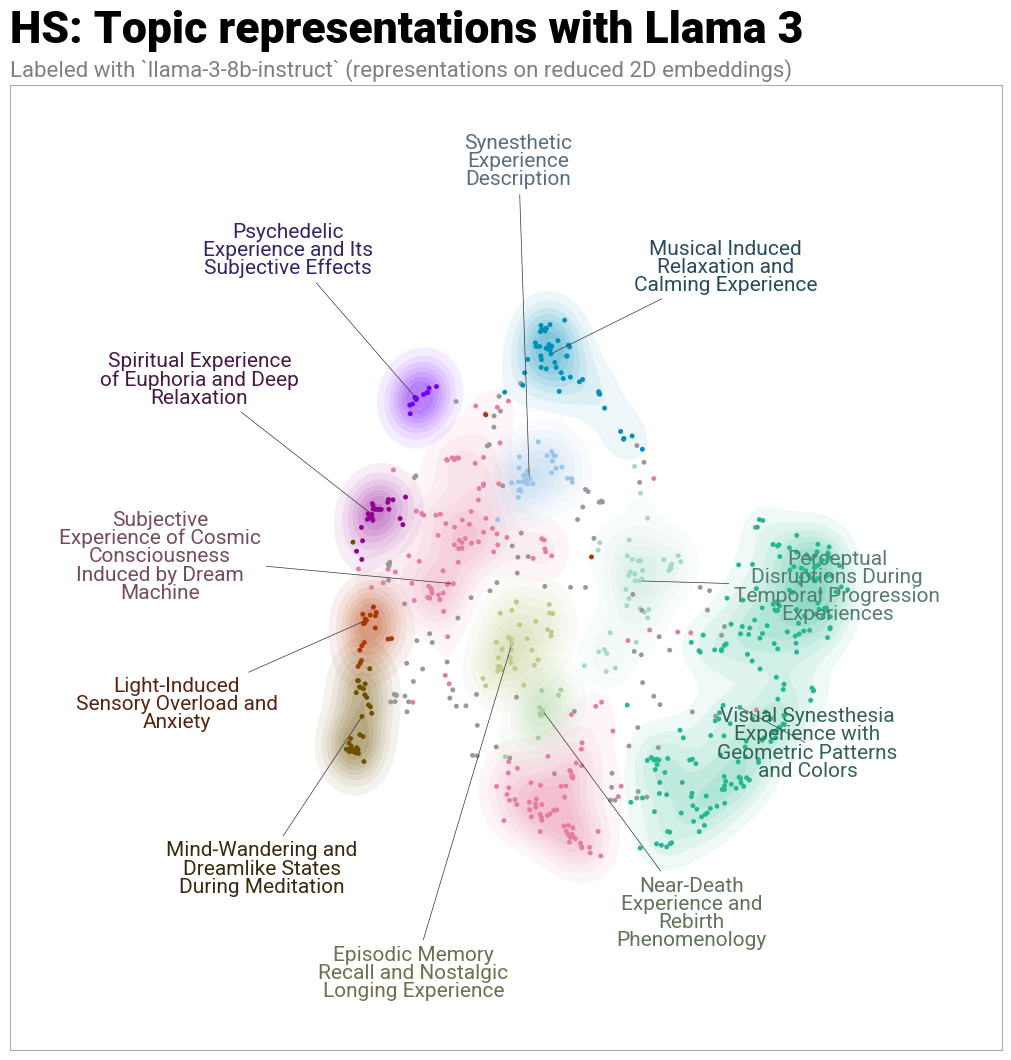

In [26]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

### create and save final topic summary

In [27]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")



Final Topic Summary:
                                          Topic_Label  Topic_Number  \
0   Visual Synesthesia Experience with Geometric P...             0   
1   Subjective Experience of Cosmic Consciousness ...             1   
2                                             Outlier            -1   
3   Musical Induced Relaxation and Calming Experience             2   
4   Perceptual Disruptions During Temporal Progres...             3   
5   Episodic Memory Recall and Nostalgic Longing E...             4   
6   Mind-Wandering and Dreamlike States During Med...             5   
7                  Synesthetic Experience Description             6   
8   Spiritual Experience of Euphoria and Deep Rela...             7   
9          Light-Induced Sensory Overload and Anxiety             8   
10  Psychedelic Experience and Its Subjective Effects             9   
11    Near-Death Experience and Rebirth Phenomenology            10   

    Sentence_Count  
0              198  
1           